# **Challenge 3: Music Genre Classification**
### Authors:
* Huỳnh Anh Nhựt
* Nguyễn Tiến Minh

### **Import thư viện**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

import optuna

### **Import dữ liệu**

In [2]:
df_train = pd.read_csv('./data/train (1).csv')
df_test = pd.read_csv('./data/test (2).csv')

df_train.head()

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,NaN,0.106,0.235,152.429,204947.0,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.0468,0.104,0.380,132.921,191956.0,4,6
2,3,Royal & the Serpent,phuck u,NaN,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.6350,0.284,0.635,159.953,161037.0,4,10
3,4,Detroit Blues Band,Missing You,12.0,0.515,0.308,NaN,-14.711,1,0.0312,0.907000,0.0213,0.300,0.501,172.472,298093.0,3,2
4,5,Coast Contra,My Lady,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,NaN,0.211,0.619,88.311,254145.0,4,5


In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14396 entries, 0 to 14395
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  14396 non-null  int64  
 1   Artist Name         14396 non-null  object 
 2   Track Name          14396 non-null  object 
 3   Popularity          14063 non-null  float64
 4   danceability        14396 non-null  float64
 5   energy              14396 non-null  float64
 6   key                 12787 non-null  float64
 7   loudness            14396 non-null  float64
 8   mode                14396 non-null  int64  
 9   speechiness         14396 non-null  float64
 10  acousticness        14396 non-null  float64
 11  instrumentalness    10855 non-null  float64
 12  liveness            14396 non-null  float64
 13  valence             14396 non-null  float64
 14  tempo               14396 non-null  float64
 15  duration_in min/ms  14396 non-null  float64
 16  time

In [47]:
df_train.describe()

,Id,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,14396.000000,14063.000000,14396.000000,14396.000000,12787.000000,14396.000000,14396.000000,14396.000000,14396.000000,10855.000000,14396.000000,14396.000000,14396.000000,1.439600e+04,14396.000000,14396.000000
mean,7198.500000,44.525208,0.543105,0.662422,5.953781,-7.900852,0.640247,0.080181,0.246746,0.178129,0.195782,0.486379,122.695372,2.000942e+05,3.924354,6.695679
std,4155.911573,17.418940,0.165517,0.235967,3.200013,4.057362,0.479944,0.085157,0.310922,0.304266,0.159258,0.239476,29.538490,1.116891e+05,0.359520,3.206170
min,1.000000,1.000000,0.059600,0.001210,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.021500,30.557000,5.016500e-01,1.000000,0.000000
25%,3599.750000,33.000000,0.432000,0.508000,3.000000,-9.538000,0.000000,0.034800,0.004280,0.000088,0.097275,0.299000,99.799000,1.654458e+05,4.000000,5.000000
50%,7198.500000,44.000000,0.545000,0.699000,6.000000,-7.013500,1.000000,0.047100,0.081450,0.003920,0.129000,0.480500,120.060000,2.089410e+05,4.000000,8.000000
75%,10797.250000,56.000000,0.658000,0.861000,9.000000,-5.162000,1.000000,0.083100,0.432250,0.201000,0.256000,0.672000,141.988250,2.522470e+05,4.000000,10.000000
max,14396.000000,100.000000,0.989000,1.000000,11.000000,1.342000,1.000000,0.955000,0.996000,0.996000,0.992000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


### **Nhận xét:**
* Tập train có 14396 dòng và 18 cột, trong đó target feature của dữ liệu là Class.
* Biến Class có phân phối từ 0 -> 10, cho thấy ta sẽ có 11 class phân loại nhạc.
* Nhìn vào bảng dữ liệu, ta thấy được các feature đa số được biểu diễn ở dạng số thực và target feature "Class" thì cũng được mã hóa bằng số nguyên.
* Có các feature chứa các dữ liệu NaN.

## **Exploratory Data Analysis (EDA)**

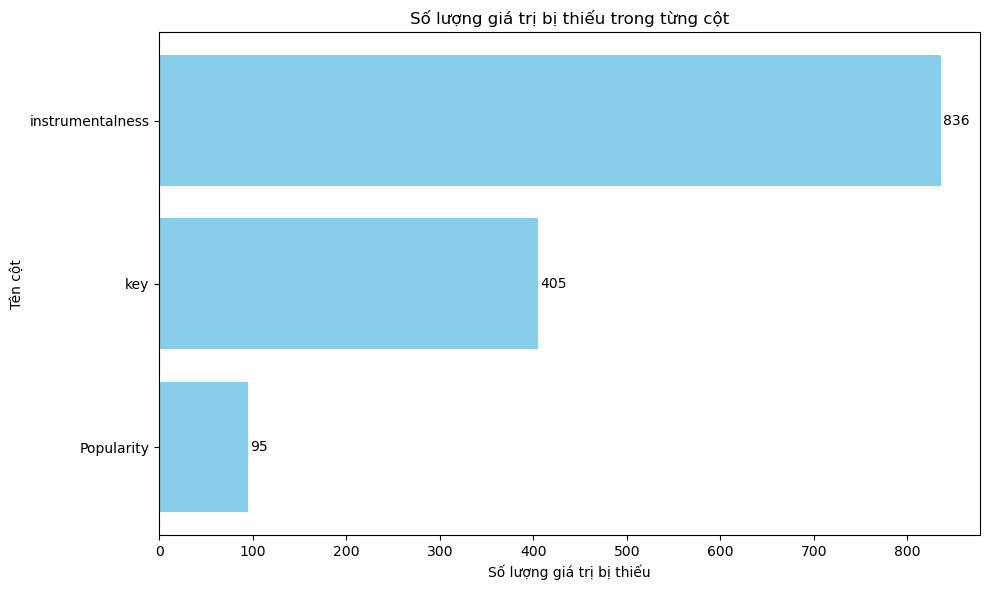

In [125]:
def missing_values(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    missing = missing[missing > 0]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(missing.index, missing.values, color='skyblue')
    plt.title('Số lượng giá trị bị thiếu trong từng cột')
    plt.xlabel('Số lượng giá trị bị thiếu')
    plt.ylabel('Tên cột')

    for bar in bars:
        xval = bar.get_width()
        plt.text(xval + 2, bar.get_y() + bar.get_height()/2, int(xval),
                va='center', fontsize=10)

    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

missing_values(df_test)

### **Nhận xét:**
* Trong tập train ta có 3 feature chứa dữ liệu missing.
* Trong đó instrumentalness có 3541 dòng missing values, key có 1609 missing value, Popularity có 333 dòng missing values.

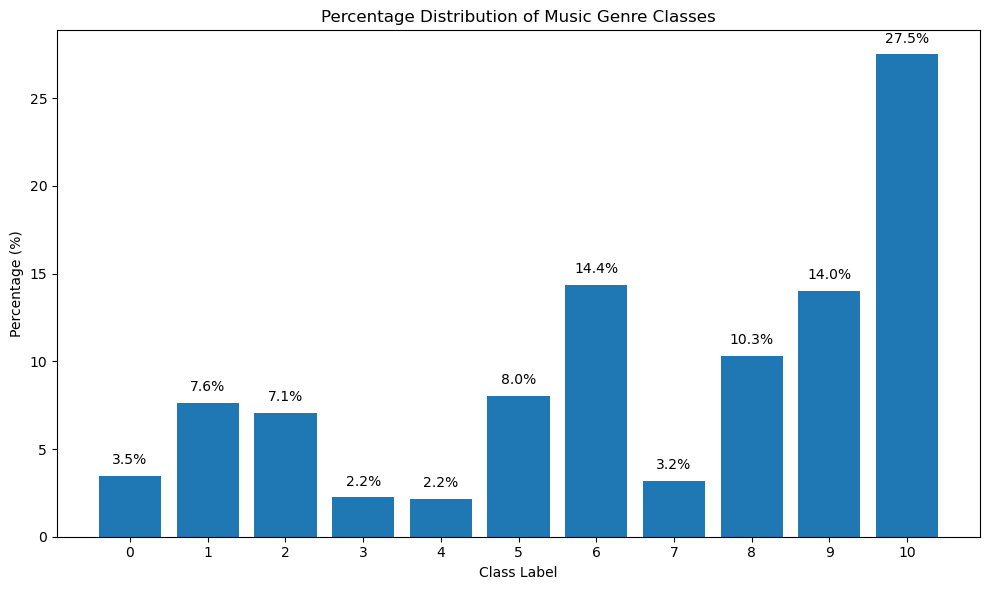

In [49]:
class_counts = df_train['Class'].value_counts().sort_index()
class_percent = (class_counts / class_counts.sum()) * 100

# Vẽ biểu đồ
plt.figure(figsize=(10,6))
bars = plt.bar(class_percent.index.astype(str), class_percent.values)

# Ghi nhãn % lên mỗi cột
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.5, f'{y:.1f}%',
             ha='center', va='bottom')

plt.title('Percentage Distribution of Music Genre Classes')
plt.xlabel('Class Label')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()

### **Nhận xét:**
* Ta thấy được dataset không được cân bằng tỉ lệ giữa các class.
* Class 10 chiếm tỷ lệ lớn nhất (≈ 27.5%), vượt trội so với các lớp còn lại → có thể là thể loại nhạc phổ biến nhất trong dataset.
* Các lớp 6 (≈ 14.4%) và 9 (≈ 14.0%) cũng chiếm tỷ lệ khá cao.
* Một số lớp chiếm tỷ lệ rất nhỏ như:<br>
    Class 3 và 4 (~2.2%)<br>
    Class 7 (~3.2%)<br>
    Class 0 (~3.5%)<br>

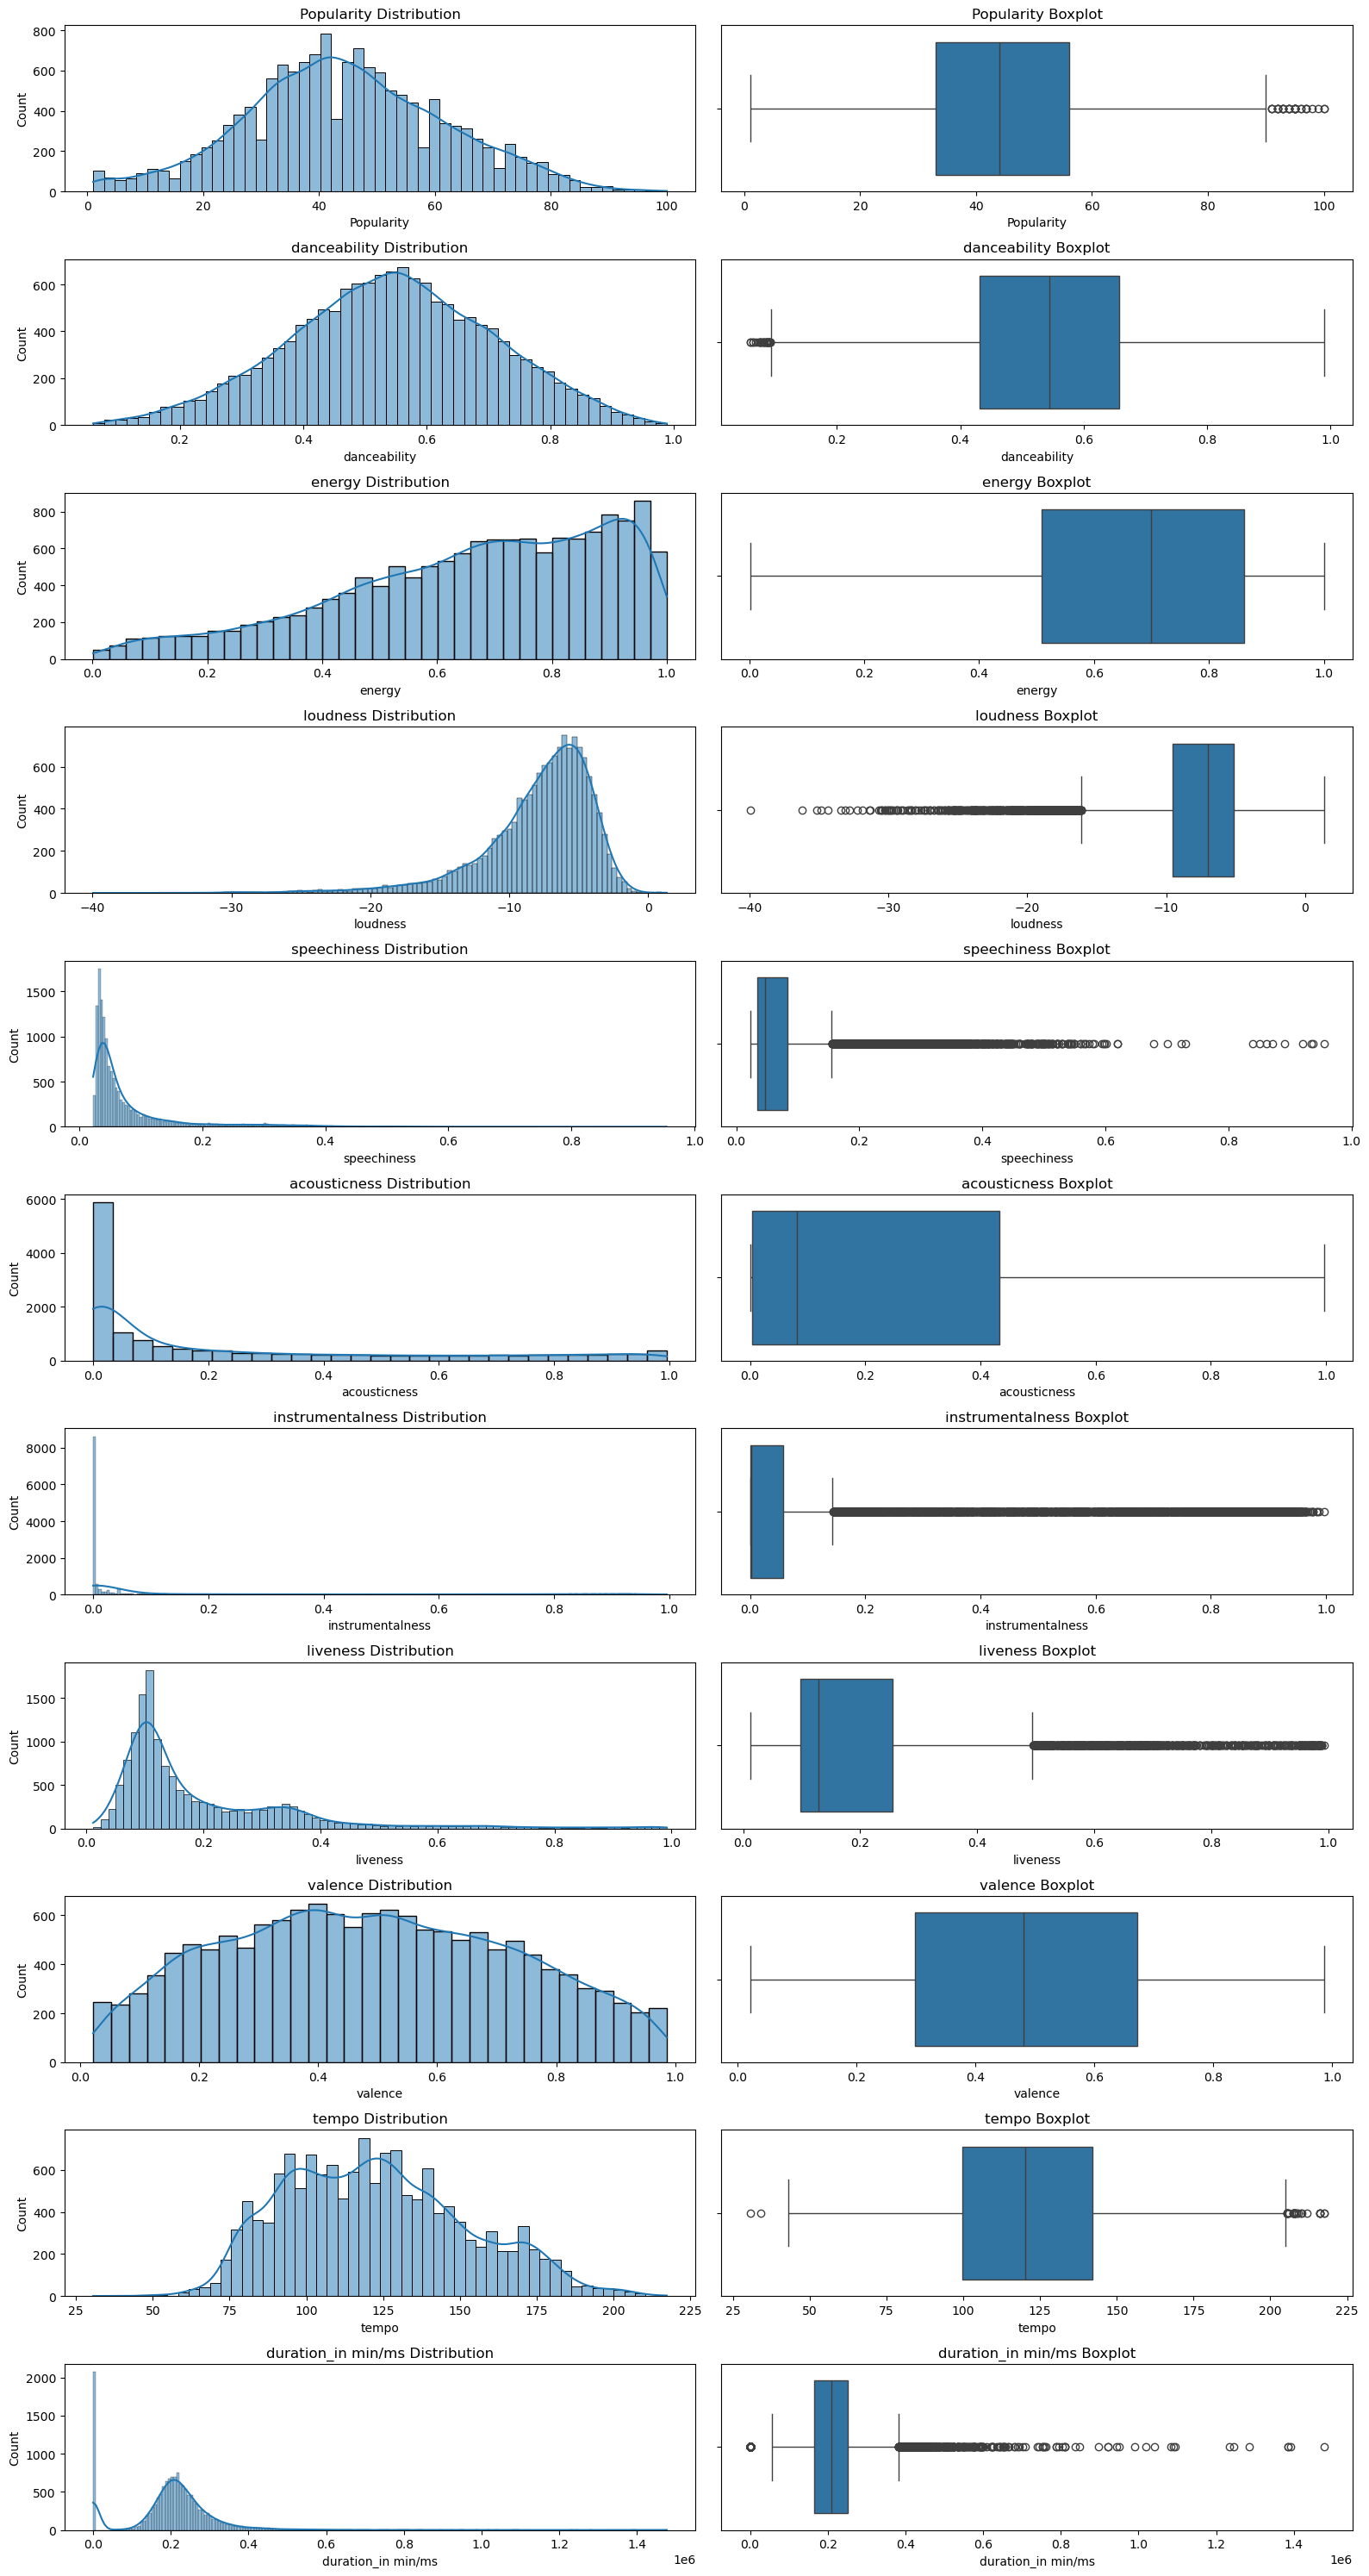

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = [
    'Popularity',
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms'
]

plt.figure(figsize=(16, 30))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(11, 2, 2*i-1)  # Histogram
    sns.histplot(df_train[feature], kde=True)
    plt.title(f'{feature} Distribution')
    
    plt.subplot(11, 2, 2*i)  # Boxplot
    sns.boxplot(x=df_train[feature])
    plt.title(f'{feature} Boxplot')

plt.tight_layout()
plt.show()


### **Nhận xét:**
* Populariry có phân phối gần chuẩn, tập trung phần lớn ở khoảng 40-60, cho thấy trong dataset phần lớn chỉ là những bài hát có độ phổ biến trung bình, ít bài flop hoặc quá hot.
* Danceability có phân phối hơi lệch nhẹ về bên phải, tập trung phần lớn 0.5-0.7 cho thấy phần lớn bài hát có độ dễ nhảy trung bình
* Energy có phân phối lệch trái rõ ràng, cho thấy phần lớn bài hát có năng lượng cao (0.7-1)
* Loudness có phân phối lệch trái, phân bố phần lớn -20 đến -5dB, có vài outlier có âm lượng cực thấp (-40dB)
* Speechiness có phân phối lệch phải mạnh, cho thấy hầu hết bài hát trong dataset không thuộc thể loại Rap/Hiphop, các outlier có speechiness cao có thể thuộc thể loại Rap
* Acousticness lệch mạnh về 0, rất ít bài hát acoustic hoàn toàn.
* Instrumentalness lệch mạnh về 0, cho thấy phần lớn bài có giọng hát, chỉ có 1 nhóm nhỏ có instrumentalness cao
* Liveness có phân phối lệch phải, tập trung phần lớn 0.1-0.2, cho thấy ít bài live
* Valence gần như có phân phối đồng đều, cho thấy dataset có sự đa dạng về cảm xúc
* Tempo có phân phối tập trung phần lớn ở (100-150BPM), một số thể loại nhạc sẽ có tempo đặc trưng, nên đây có thể là feature hữu ích cho việc phân lớp
* Duration_in min/ms có phân phối tập trung phần lớn ở 0.15 - 0.3, có rất nhiều outlier phía phải cho thấy một số bài dài bất thường

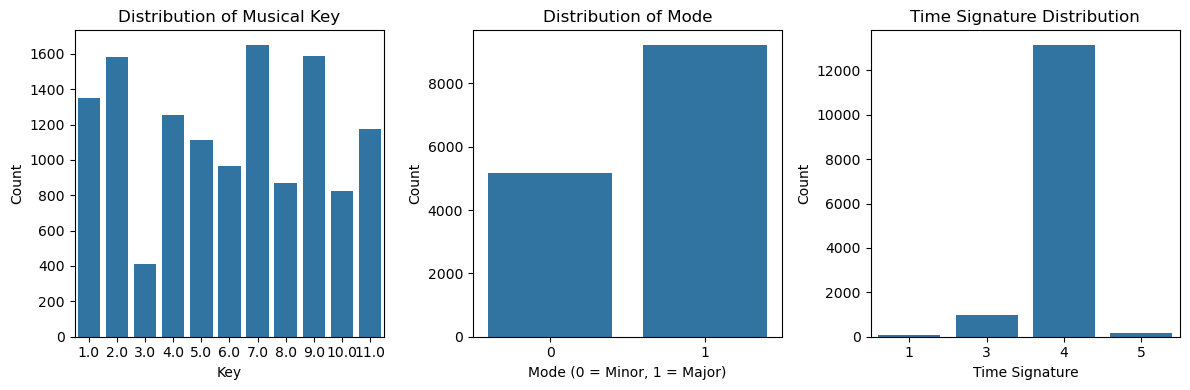

In [51]:
plt.figure(figsize=(12,4))

# Key Countplot
plt.subplot(1,3,1)
sns.countplot(x=df_train['key'])
plt.title('Distribution of Musical Key')
plt.xlabel('Key')
plt.ylabel('Count')

# Mode Countplot
plt.subplot(1,3,2)
sns.countplot(x=df_train['mode'])
plt.title('Distribution of Mode')
plt.xlabel('Mode (0 = Minor, 1 = Major)')
plt.ylabel('Count')

plt.subplot(1,3,3)
sns.countplot(x=df_train['time_signature'])
plt.title('Time Signature Distribution')
plt.xlabel('Time Signature')
plt.ylabel('Count')


plt.tight_layout()
plt.show()

### **Nhận xét:**
* Phân phối của key không đồng đều. Một số key phổ biến hơn trong nhạc thị trường.
* Mode == major (1) chênh lệch chiếm phần lớn, cho thấy thị trường có xu hướng âm nhạc sôi động, vui vẻ, dễ nghe.
* Hầu hết các bài đều có time signature là 4, cho thấy đây là nhịp điệu phổ biến trong âm nhạc đại chúng, các nhịp khác như 1,3,5 xuất hiện với tần suất thấp hơn rất nhiều, đây là biến ít thông tin phân loại.

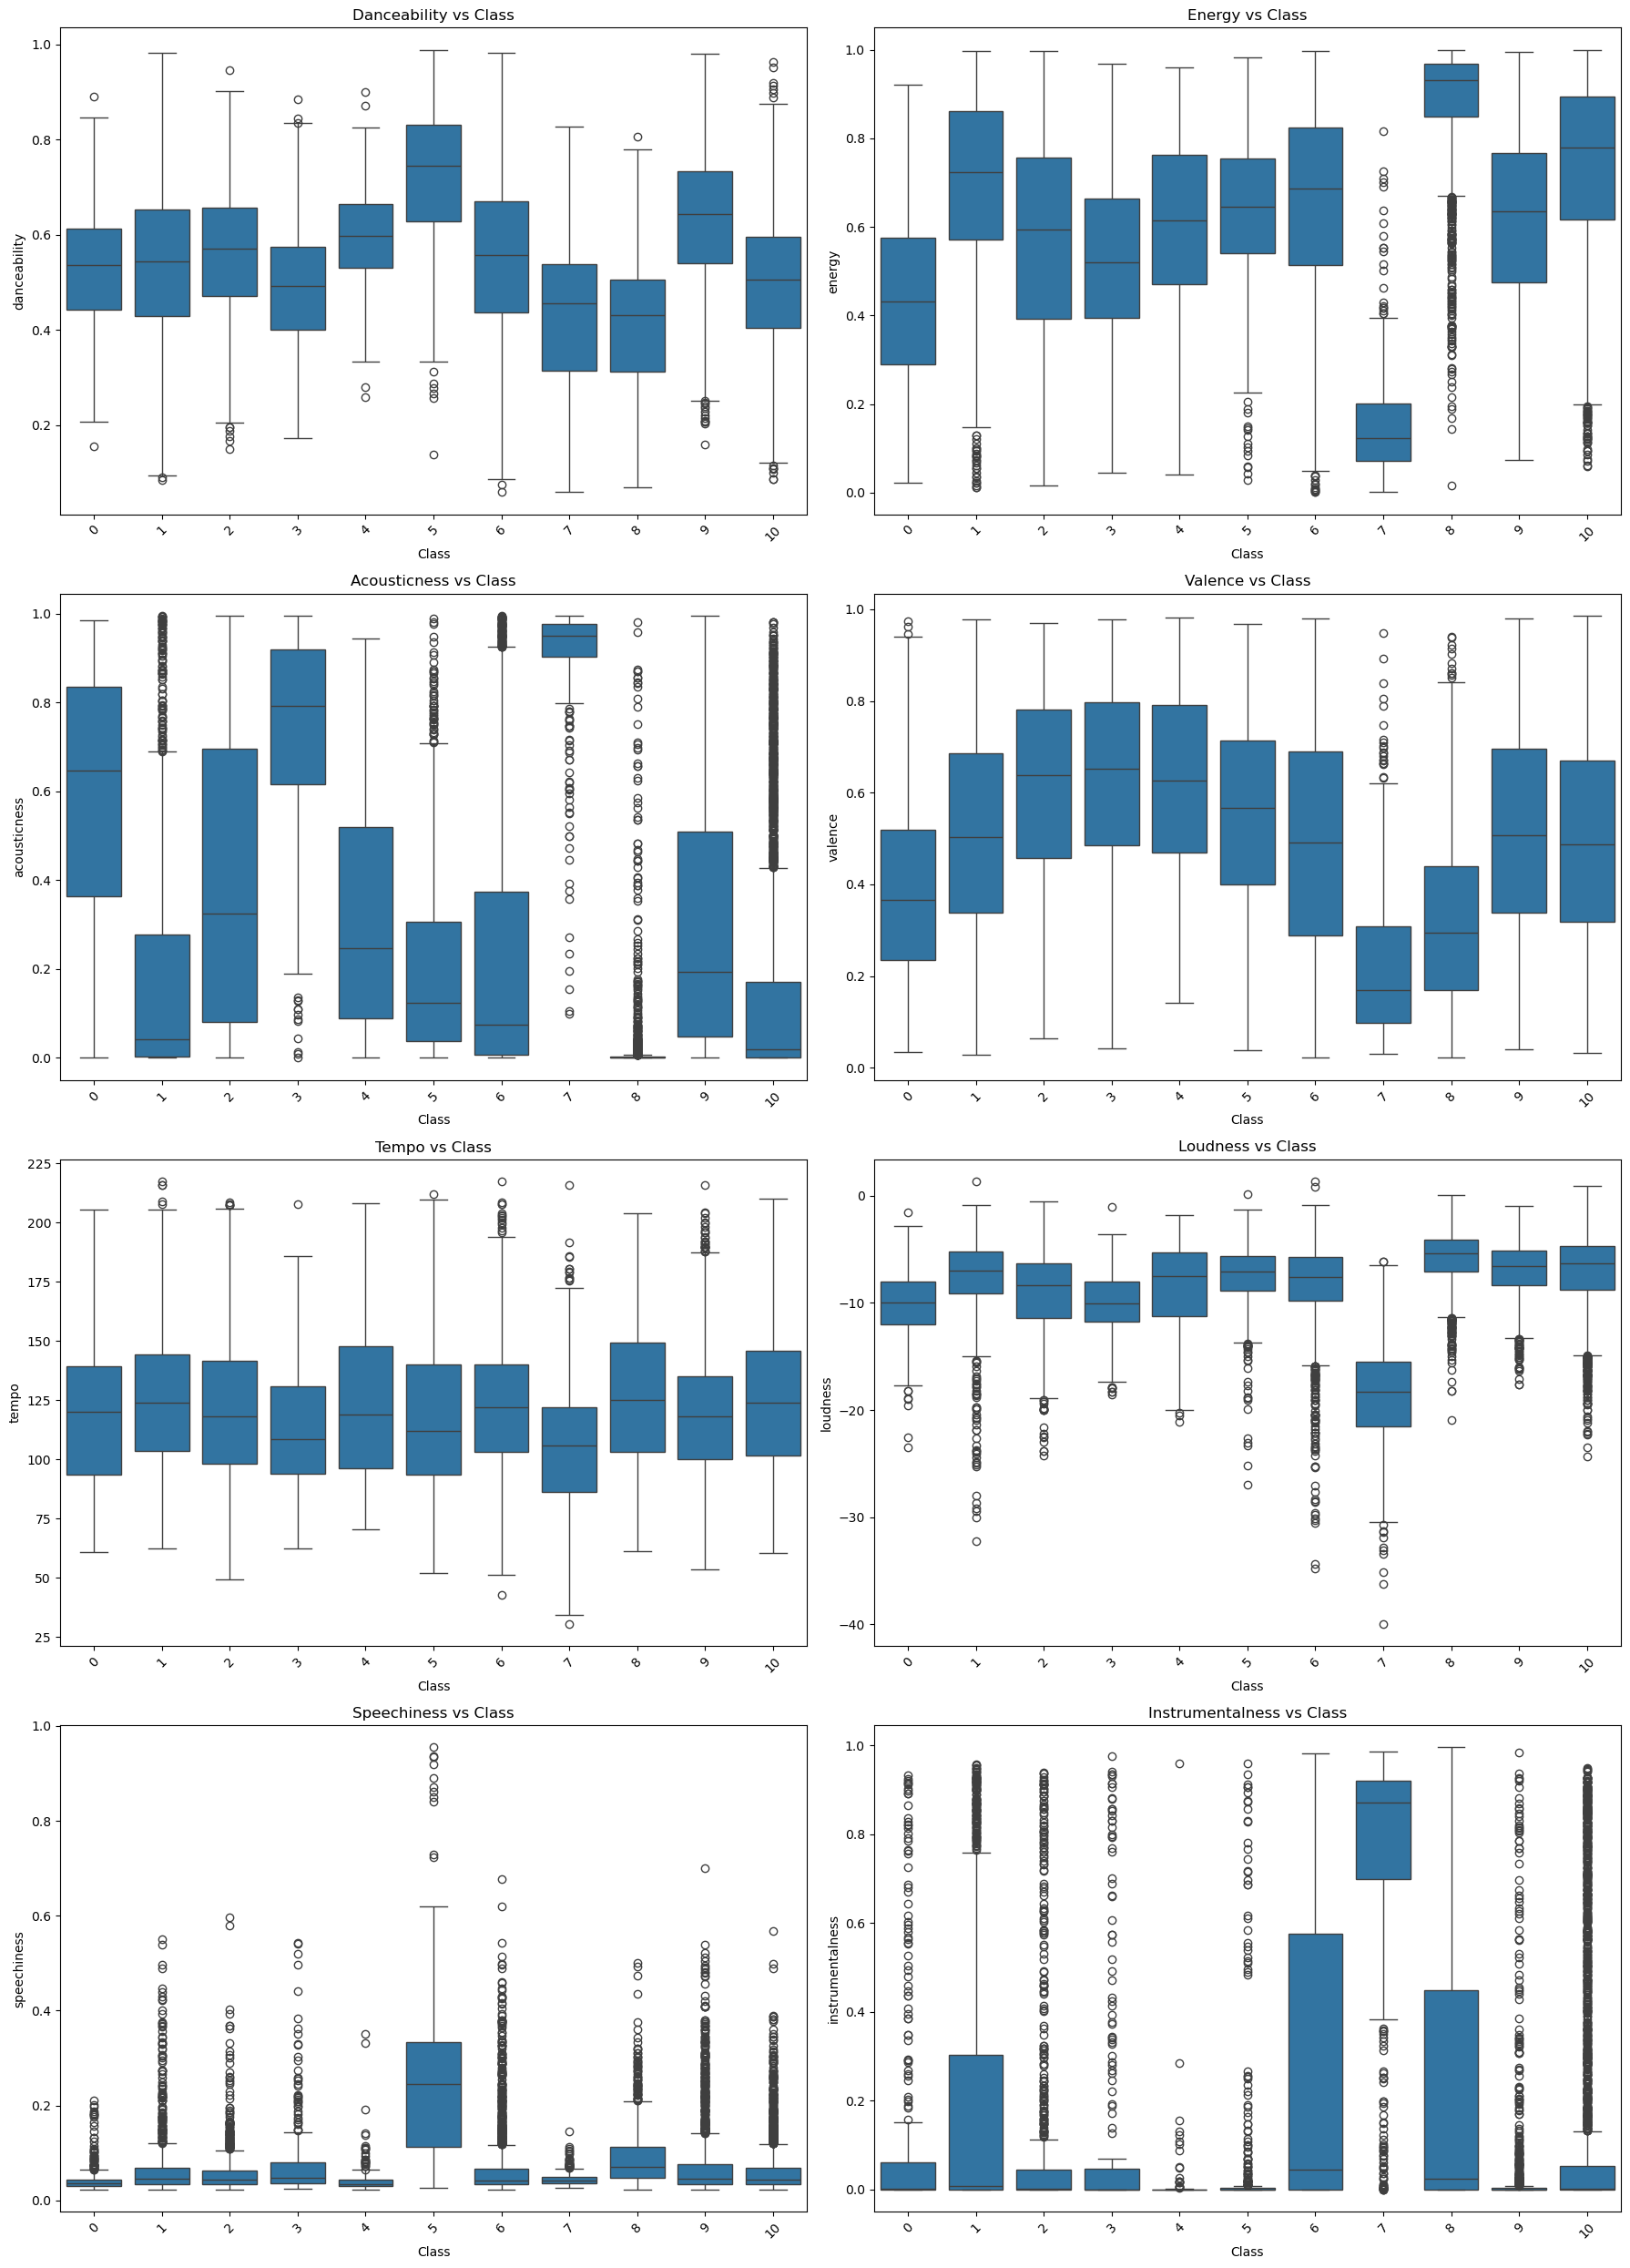

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['danceability', 'energy', 'acousticness', 'valence',
            'tempo', 'loudness', 'speechiness', 'instrumentalness']

plt.figure(figsize=(18, 25))
for i, col in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=df_train, x='Class', y=col)
    plt.title(f'{col.capitalize()} vs Class')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


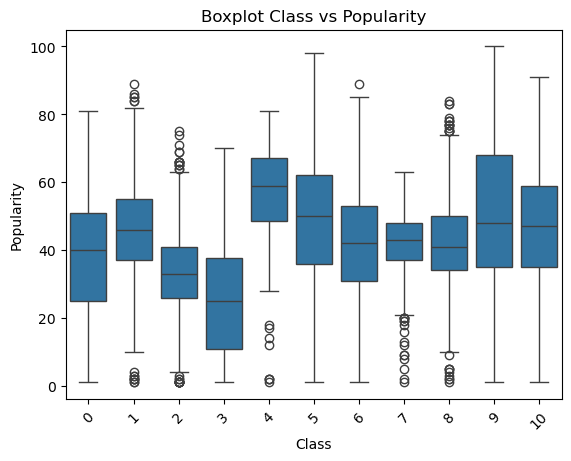

In [53]:
sns.boxplot(data=df_train, x='Class', y='Popularity')
plt.title('Boxplot Class vs Popularity')
plt.xticks(rotation=45);

### **Nhận xét:**
* Ta thấy các class đều có độ phổ biến khác nhau rõ rệt, popularity của Class 4 có median cao nhất và của class 3 là thấp nhất.
* Một số class 1,2,8 có vài bài khá nổi tiếng nhưng cũng có bài flop.


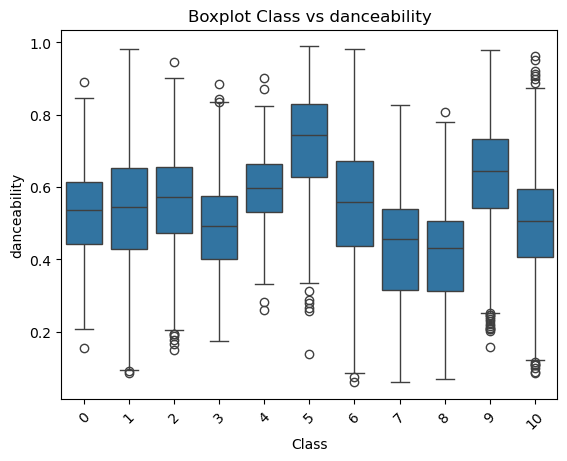

In [54]:
sns.boxplot(data=df_train, x='Class', y='danceability')
plt.title('Boxplot Class vs danceability')
plt.xticks(rotation=45);

## **Nhận xét:**
* Các class đều có danceability từ trung bình đến cao.
* Danceability giữa các class khác biệt không quá lớn. 

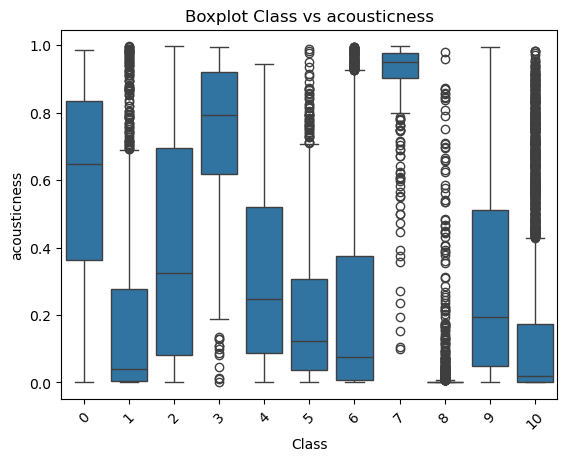

In [55]:
sns.boxplot(data=df_train, x='Class', y='acousticness')
plt.title('Boxplot Class vs acousticness')
plt.xticks(rotation=45);

### **Nhận xét:**
* Acousticness phân tách rõ ràng giữa các class
* Các class 0, 3, 7 có acousticness cao còn lại thì các class đều có acousticness từ trung bình tới thấp

## **Nhận xét:**
* Các class có độ acousticness khác nhau rỗ rệt.
* Một số class 3, 7 ở mức cao và số còn lại từ trung bình tới thấp
* Các class như 1, 7, 8, 10 có nhiều outlier trải dài từ trung bình đến cao

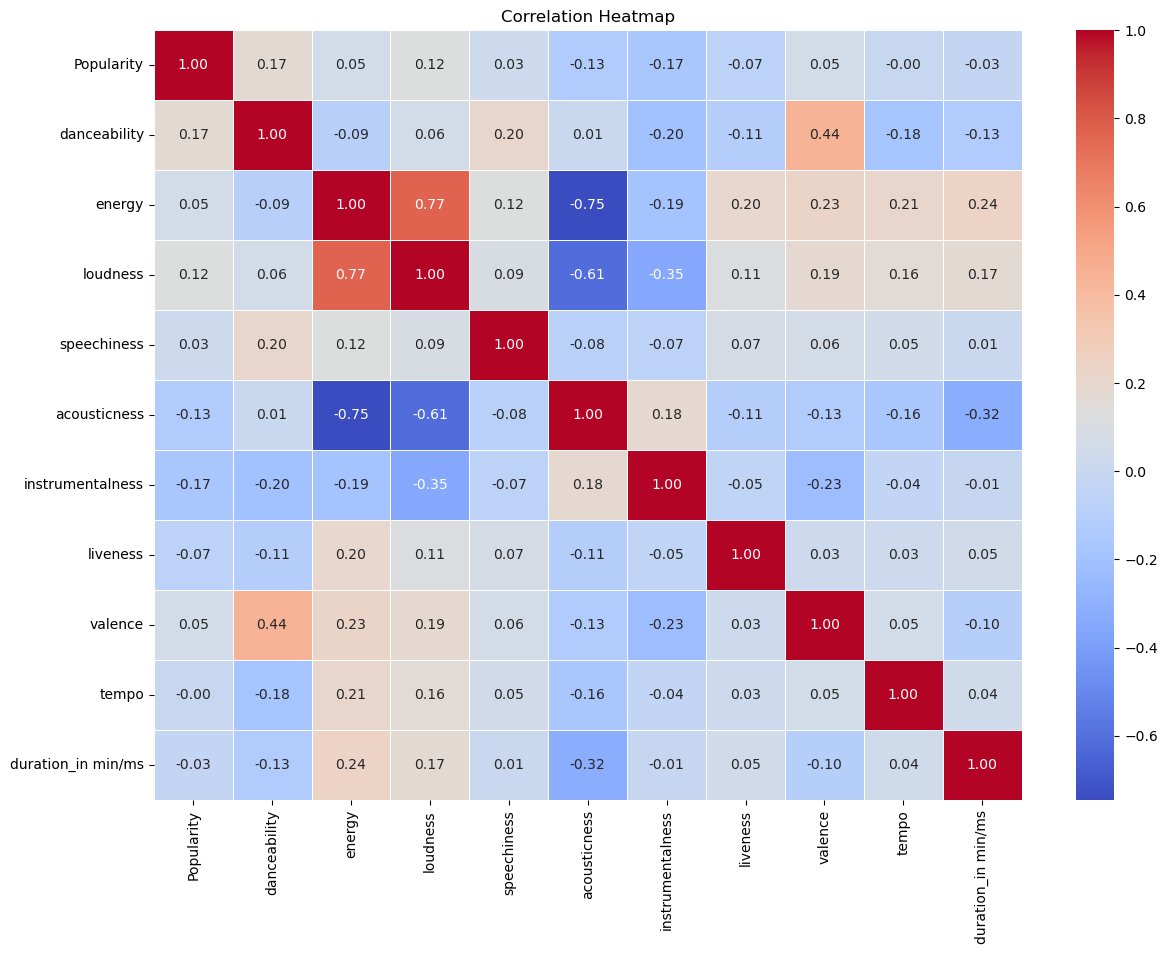

In [56]:
numeric_df = df_train[numeric_features]

corr = numeric_df.corr()

plt.figure(figsize=(14, 10))

sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### **Nhận xét:**
* Energy tương quan cao với Loudness, khá dễ hiểu khi bài nhạc có âm lượng càng lớn thì bài nhạc càng nhiều năng lượng.
* Energy, Loudness tương quan nghịch với Acousticness, nhạc acoustic cao thường là các loại nhạc nhẹ nhàng, ít năng lượng hơn.
* Danceability tương quan tốt với Valence, các bài có độ nhảy cao thường mang cảm xúc tích cực hơn.
* Popularity tương quan khá thấp với các feature khác, suy ra một bài nhạc muốn nổi tiếng thì cần nhiều yếu tốt khác nhau.


# **Data Preprocessing**


### **Drop các feature không cần thiết**


In [3]:
features_to_drop = ['Id', 'Artist Name', 'Track Name']

df_train.drop(labels=features_to_drop, axis=1, inplace=True)
df_test.drop(labels=features_to_drop, axis=1, inplace=True)

df_train.head()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,NaN,0.106,0.235,152.429,204947.0,4,9
1,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.0468,0.104,0.380,132.921,191956.0,4,6
2,NaN,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.6350,0.284,0.635,159.953,161037.0,4,10
3,12.0,0.515,0.308,NaN,-14.711,1,0.0312,0.907000,0.0213,0.300,0.501,172.472,298093.0,3,2
4,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,NaN,0.211,0.619,88.311,254145.0,4,5


### **Fill missing value**

In [4]:
def fill_missing_values(df_train, df_test):

    df_train['instrumentalness'] = df_train['instrumentalness'].fillna(0)
    # Fill 'key' with mode based on Class
    df_train['key'] = df_train['key'].fillna(df_train['key'].mode()[0])

    # Fill 'Popularity' with median based on Class
    df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].median())

    df_test['instrumentalness'] = df_test['instrumentalness'].fillna(0)
    # Fill 'key' with mode based on Class
    df_test['key'] = df_test['key'].fillna(df_test['key'].mode()[0])

    # Fill 'Popularity' with median based on Class
    df_test['Popularity'] = df_test['Popularity'].fillna(df_test['Popularity'].median())
    
   

    return df_train, df_test


df_train, df_test = fill_missing_values(df_train, df_test)


## **Feature engineering**


In [5]:
# # ohe các feature phân loại (key, mode, time_signature)

def create_new_features(df):
    df = df.copy()  # tránh thay đổi DataFrame gốc

    df['loudness_scaled'] = df['loudness'].abs()

    # 2️⃣ Power-based features
    df['power_intensity'] = (df['energy'] + df['loudness_scaled']) / 2
    df['energy_loudness_ratio'] = df['energy'] / (df['loudness_scaled'] + 1e-6)
    df['acousticness_energy_ratio'] = df['acousticness'] / (df['energy'] + 1e-6)

    # 3️⃣ Acoustic vs Electronic profile
    df['sound_profile'] = df['energy'] - df['acousticness']

    # 4️⃣ Mood Score (Nhạc vui và dễ nhảy)
    df['mood_score'] = (df['danceability'] + df['valence']) / 2

    # 5️⃣ Long acoustic songs (ballad)
    df['long_acoustic'] = ((df['duration_in min/ms'] > df['duration_in min/ms'].median()) &
                           (df['acousticness'] > 0.5)).astype(int)

    # 6️⃣ Music type (3 groups → one-hot)
    df['music_type'] = np.where(df['acousticness'] > 0.6, 'acoustic',
                         np.where(df['energy'] > 0.6, 'electronic', 'mixed'))
    df = pd.get_dummies(df, columns=['music_type', 'key', 'mode', 'time_signature'], drop_first=True)

    return df

df_train = create_new_features(df_train)
df_test = create_new_features(df_test)

In [129]:
df_train.head()

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,mode_1,time_signature_3,time_signature_4,time_signature_5
0,37.0,0.334,0.536,-6.649,0.0381,0.378000,0.0000,0.106,0.235,152.429,...,False,False,False,True,False,False,False,False,True,False
1,67.0,0.725,0.747,-5.545,0.0876,0.027200,0.0468,0.104,0.380,132.921,...,False,False,False,False,False,True,True,False,True,False
2,44.0,0.584,0.804,-6.094,0.0619,0.000968,0.6350,0.284,0.635,159.953,...,False,True,False,False,False,False,True,False,True,False
3,12.0,0.515,0.308,-14.711,0.0312,0.907000,0.0213,0.300,0.501,172.472,...,False,True,False,False,False,False,True,True,False,False
4,48.0,0.565,0.777,-5.096,0.2490,0.183000,0.0000,0.211,0.619,88.311,...,True,False,False,False,False,False,False,False,True,False


### **Skew check**

In [6]:
import scipy.stats
numerical_cols = [ cname for cname in df_train.columns if df_train[cname].dtypes!= 'bool' and cname != 'Class']


skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df_train[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].abs()
skew_df['Skew'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

In [7]:
skew_df

,Feature,Skew,Absolute Skew
0,Popularity,False,0.078788
1,danceability,False,0.075643
2,energy,True,0.656630
3,loudness,True,1.747891
4,speechiness,True,3.113071
5,acousticness,True,1.108817
6,instrumentalness,True,1.970423
7,liveness,True,2.178038
8,valence,False,0.088678
9,tempo,False,0.376468


In [120]:
for col in skew_df[skew_df['Skew'] == True]['Feature']:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])

c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## **Pipeline processing**

In [8]:
log_features = [x for x in skew_df[skew_df['Skew'] == True]['Feature']]
dummy_features = [x for x in df_train.columns if x if set(df_train[x].dropna().unique()).issubset({0,1})]
other_features = [x for x in df_train.columns if x not in log_features and x not in dummy_features and x != 'Class']



In [9]:
log_transform = Pipeline(steps=[
    ('log', FunctionTransformer(
        lambda x: np.log1p(np.clip(x, 0, None)),
        feature_names_out="one-to-one"
)),
    ('scaler', StandardScaler())
])

other_transform = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transform, log_features),
        ('scale', other_transform, other_features),
        ('dummy', 'passthrough', dummy_features)
    ],
    remainder='drop'
)

## **Train model**

### **Tách train và validation**

In [10]:
X = df_train.drop(columns='Class')
y = df_train['Class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### **Khởi tạo model**

In [11]:
models = {
    "CatBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('model',  CatBoostClassifier(iterations=1200,
                                    learning_rate=0.05,
                                    depth=8,
                                    loss_function='MultiClass',
                                    verbose=0))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(n_estimators=500,
                                max_depth=8,
                                learning_rate=0.03,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                objective='multi:softprob',  # note softprob
                                num_class=9,
                                eval_metric='mlogloss'))
    ]),
    # "RandomForest": Pipeline([
    #     ('preprocessor', preprocessor),
    #     ('model', RandomForestClassifier())
    # ]),
    # "SVM": Pipeline([
    #     ('preprocessor', preprocessor),
    #     ('model', SVC(probability=True))
    # ]),
    # "LogisticRegression": Pipeline([
    #     ('preprocessor', preprocessor),
    #     ('models', LogisticRegression(max_iter=2000))
    # ]),
    # 'LightGBM': Pipeline([
    #     ('preprocessor', preprocessor),
    #     ('model', LGBMClassifier())
    # ])
}

In [111]:
from sklearn.metrics import f1_score

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"{name} -> F1 Macro: {f1:.4f}")


CatBoost -> F1 Macro: 0.6725
XGBoost -> F1 Macro: 0.6801


### **Nhận xét**
* Sau khi đánh giá thì kết quả cho ra 3 model tốt nhất và nên đem đi tuning là Catboost, XGBoost, LightGBM
* RF, LR và SVM cho thấy sự kém hiệu quả rõ rệt so với 3 model trên

## **Hyperparameter Tuning**

In [12]:
def objective(trial):

    model_name = trial.suggest_categorical("model", ["catboost", "xgboost", "lightgbm"])

    if model_name == "catboost":
        params = {
            "iterations": trial.suggest_int("iterations", 300, 1200),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "loss_function": "MultiClass",
            "eval_metric": "TotalF1",
            "verbose": 0,
            "task_type": "CPU",
            # 🚫 remove subsample
        }
        model = CatBoostClassifier(**params)

    elif model_name == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "eval_metric": "mlogloss",
            "objective": "multi:softprob"
        }
        model = XGBClassifier(**params, tree_method="auto")

    else:  # lightgbm
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
            "max_depth": trial.suggest_int("max_depth", -1, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 16, 256),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "objective": "multiclass",
            "metric": "multi_logloss"
        }
        model = LGBMClassifier(**params)

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model),
    ])

    score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        scoring="f1_macro",
        cv=5,
        n_jobs=-1
    ).mean()

    return score


In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("🥇 Best F1 Macro:", study.best_value)
print("🏆 Best Params:", study.best_params)


[I 2025-12-03 08:22:45,449] A new study created in memory with name: no-name-3f49633f-f286-48c1-ac0f-56a025814725
[W 2025-12-03 08:23:51,832] Trial 0 failed with parameters: {'model': 'catboost', 'iterations': 362, 'depth': 7, 'learning_rate': 0.016719602642632066, 'l2_leaf_reg': 0.03938551499100753} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\MSI VN\AppData\Local\Temp\ipykernel_13088\1067441655.py", line 50, in objective
    score = cross_val_score(
            ^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 712, in cros

KeyboardInterrupt: 

In [83]:
models_params = [
    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', XGBClassifier(eval_metric='mlogloss'))
        ]),
        {
            'model__n_estimators': [200, 400, 600],
            'model__num_leaves': [31, 63, 127],
            'model__learning_rate': [0.01, 0.1, 0.2],
        },
        'XGBClassifier'
    ),
    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', CatBoostClassifier(loss_function='MultiClass', verbose=0))
        ]),
        {
            'model__n_estimators': [200, 400, 600],
            'model__num_leaves': [31, 63, 127],
            'model__learning_rate': [0.01, 0.1, 0.2],
        },
        'CatBoostClassifier'
    ),
    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', LGBMClassifier(objective='multiclass'))
        ]),
        {
            'model__iterations': [200, 500],
            'model__depth': [4, 6, 8],
            'model__learning_rate': [0.01, 0.1],
        },
        'LGBMClassifier'
    )
]

for model, params, name in models_params:
    print(f"\nTuning {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best accuracy: {grid.best_score_:.4f}")



Tuning XGBClassifier...


KeyboardInterrupt: 

### **Submit**

In [138]:

for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(df_test)

    submission = pd.read_csv('./data/sample_submission (2).csv')
    submission['Class'] = y_pred.astype(int)
    submission.to_csv(f'./submissions/{name.replace(" ", "_").lower()}submission.csv', index=False)
    print(f'Đã tạo file {name} submission.')



Đã tạo file CatBoost submission.
Đã tạo file XGBoost submission.


## **Experiment**
* Chưa có tuning score 0.45-0.47
* fill mising data đúng điểm cao hơn, score 0.52-0.53 
* Khi standarscaler và ko cũng ko ảnh hưởng đến kq lắm